# Grover's algorithm

Grover search circuit

In [2]:
import math
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution, plot_histogram
from qiskit.primitives import Sampler

Query function

In [3]:
def query_function(marked_states):
    """
    Creates the oracle quantum circuit

    Parameters:
    marked_states (list of str): List of bit strings representing the states to be marked as 'good'.

    Returns:
    QuantumCircuit: The quantum circuit representing the phase oracle.    
    """
    
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    
    num_qubits = len(marked_states[0])
    qc = QuantumCircuit(num_qubits)
 
    # mark each target state in the input list
    for state in marked_states:
        
        # flip bit-string to match Qiskit bit-ordering
        state = state[::-1]
        
        # find the indices of all the '0' elements in bit-string
        zero_indices = [i for i in range(num_qubits) if state.startswith('0', i)]
        
        # add a multi-controlled Z-gate with pre- and post-applied X-gates where the target bit-string has a '0' entry
        if len(zero_indices) > 0:
            qc.x(zero_indices)
            qc.compose(MCMT(gate='z', num_ctrl_qubits=num_qubits-1, num_target_qubits=1), inplace=True)
            qc.x(zero_indices)
        else:
            qc.compose(MCMT(gate='z', num_ctrl_qubits=num_qubits-1, num_target_qubits=1), inplace=True)
    
    return qc

Visualize circuit

In [4]:
# list of marked states
marked_states = ['011']

# construct the oracle circuit
oracle = query_function(marked_states)

# draw the oracle circuit
oracle.draw()

q_0: ──────■──────
           │      
q_1: ──────■──────
     ┌───┐ │ ┌───┐
q_2: ┤ X ├─■─┤ X ├
     └───┘   └───┘

Grover operator

In [5]:
# qiskit implementation
grover_operator = GroverOperator(oracle)
grover_operator.decompose().draw()

global phase: π
                 ┌───┐┌───┐               ┌───┐┌───┐     
state_0: ──────■─┤ H ├┤ X ├────────────■──┤ X ├┤ H ├─────
               │ ├───┤├───┤            │  ├───┤├───┤     
state_1: ──────■─┤ H ├┤ X ├────────────■──┤ X ├┤ H ├─────
         ┌───┐ │ ├───┤├───┤┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐
state_2: ┤ X ├─■─┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
         └───┘   └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘

In [6]:
# compute the optimal number of iterations for Grover's algorithm
optimal_num_iterations = math.floor(math.pi / (4*math.asin(math.sqrt(len(marked_states)/2**grover_operator.num_qubits))))
print(f'Optimal number of iterations: {optimal_num_iterations}')

Optimal number of iterations: 2


Full Grover circuit

In [7]:
# initialize the quantum circuit
qc = QuantumCircuit(grover_operator.num_qubits)

# create even superposition of all basis states
qc.h(range(grover_operator.num_qubits))

# apply Grover operator the optimal number of times
qc.compose(grover_operator.power(optimal_num_iterations), inplace=True)

# measure all qubits
qc.measure_all()

qc.draw()

┌───┐┌────┐┌────┐ ░ ┌─┐      
   q_0: ┤ H ├┤0   ├┤0   ├─░─┤M├──────
        ├───┤│    ││    │ ░ └╥┘┌─┐   
   q_1: ┤ H ├┤1 Q ├┤1 Q ├─░──╫─┤M├───
        ├───┤│    ││    │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├┤2   ├┤2   ├─░──╫──╫─┤M├
        └───┘└────┘└────┘ ░  ║  ║ └╥┘
meas: 3/═════════════════════╩══╩══╩═
                             0  1  2

Execute quantum circuit and post-process

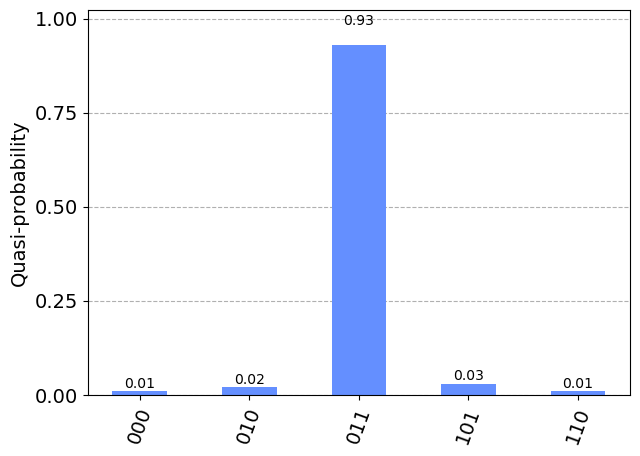

In [8]:
# use the Sampler from qiskit.primitives for local statevector simulation
sampler = Sampler()

# run the circuit with shots=100
job = sampler.run(qc, shots=100, seed=42)

# get the result of the job
job_result = job.result()

# get the counts from the result
counts = job_result.quasi_dists[0]
plot_distribution(counts.binary_probabilities())

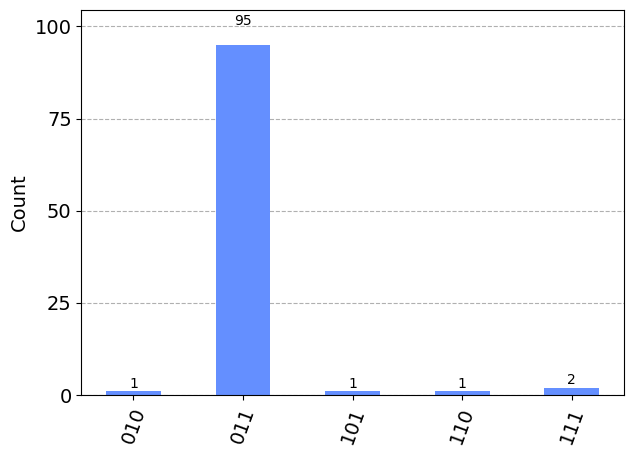

In [9]:
# qasm as backend
simulator = Aer.get_backend('qasm_simulator')
qc_transpiled = transpile(qc, simulator, optimization_level=1)
job = simulator.run(qc_transpiled, shots=100, seed=42)
job_result = job.result() 
counts = job_result.get_counts(qc_transpiled)
plot_distribution(counts)
plot_histogram(counts)

In [10]:
qc_transpiled.draw()

┌───┐               ┌───┐┌───┐                    ┌───┐┌───┐          »
   q_0: ┤ H ├────────────■──┤ H ├┤ X ├─────────────────■──┤ X ├┤ H ├──────────»
        ├───┤            │  ├───┤├───┤                 │  ├───┤├───┤          »
   q_1: ┤ H ├────────────■──┤ H ├┤ X ├─────────────────■──┤ X ├┤ H ├──────────»
        ├───┤┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐»
   q_2: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├»
        └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
meas: 3/══════════════════════════════════════════════════════════════════════»
                                                                              »
«                  ┌───┐┌───┐                    ┌───┐┌───┐      ░ ┌─┐      
«   q_0: ───────■──┤ H ├┤ X ├─────────────────■──┤ X ├┤ H ├──────░─┤M├──────
«               │  ├───┤├───┤                 │  ├───┤├───┤      ░ └╥┘┌─┐   
«   q_1: ───────■──┤ H ├┤ X ├─────────────────■──┤ X ├┤ H ├──────░──╫─┤M├───
«        ┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐ ░  ║ └╥┘┌─┐
«   q_2: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─░──╫──╫─┤M├
«        └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘ ░  ║  ║ └╥┘
«meas: 3/═══════════════════════════════════════════════════════════╩══╩══╩═
«                                                                   0  1  2